In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_ind_main = pd.read_excel('COVID19 India Complete Dataset April 2020.xlsx', sheet_name='Raw Data')
df_ind_main.head(2)

,Patient Number,State Patient Number,Date Announced,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Current Status,Notes,Contracted from which Patient (Suspected),Nationality,Type of transmission,Status Change Date,Source_1,Source_2,Source_3,Backup Notes
0,1900-01-01 00:00:00,KL-TS-P1,2020-01-30,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
1,1900-01-02 00:00:00,KL-AL-P1,2020-02-02,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan


In [3]:
df_ind_main = df_ind_main.dropna(subset=['Date Announced'])
df_ind_main.reset_index(drop=True)
df_ind_main = df_ind_main.drop_duplicates(subset=df_ind_main.drop('Patient Number', axis=1).columns)
df_ind_main.reset_index(drop=True)
df_ind_main.head(2)

,Patient Number,State Patient Number,Date Announced,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Current Status,Notes,Contracted from which Patient (Suspected),Nationality,Type of transmission,Status Change Date,Source_1,Source_2,Source_3,Backup Notes
0,1900-01-01 00:00:00,KL-TS-P1,2020-01-30,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
1,1900-01-02 00:00:00,KL-AL-P1,2020-02-02,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan


In [4]:
dbd_tc_india = pd.read_excel('COVID19 India Complete Dataset April 2020.xlsx', sheet_name='Daily Cases Time-Series')
dbd_tc_india.head(2)

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,2020-01-30,1,1,0,0,0,0
1,2020-01-31,0,1,0,0,0,0


In [5]:
db_india = pd.DataFrame(dbd_tc_india.groupby(['Date'])['Total Confirmed'].sum()).reset_index()
db_india.head(3)

,Date,Total Confirmed
0,2020-01-30,1
1,2020-01-31,1
2,2020-02-01,1


In [6]:
dbd_tc_param = pd.DataFrame(dbd_tc_india.groupby(['Date'])['Total Confirmed','Total Recovered', \
                                                           'Total Deceased'].sum().reset_index())
dbd_tc_param.head(3)

,Date,Total Confirmed,Total Recovered,Total Deceased
0,2020-01-30,1,0,0
1,2020-01-31,1,0,0
2,2020-02-01,1,0,0


In [7]:
dbd_tc_param['Total Active Cases'] = dbd_tc_param['Total Confirmed'] - dbd_tc_param['Total Recovered'] - \
                                     dbd_tc_param['Total Deceased']

In [8]:
dbd_tc_pl = dbd_tc_param[(dbd_tc_param['Date']>'2020-03-01') & (dbd_tc_param['Date']<'2020-03-27')].reset_index(drop=True) # considering pre lockdown period
dbd_tc_pl.head(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
0,2020-03-02,5,3,0,2
1,2020-03-03,6,3,0,3


In [9]:
dbd_tc_pl.tail(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
23,2020-03-25,657,43,11,603
24,2020-03-26,730,50,16,664


In [10]:
dbd_tc_pl.shape

(25, 5)

In [11]:
dbd_tc_param['Total Active Cases'] = dbd_tc_param['Total Confirmed'] - dbd_tc_param['Total Recovered'] - \
                                     dbd_tc_param['Total Deceased']

In [12]:
dbd_tc_param = dbd_tc_param[dbd_tc_param['Date']>='2020-03-27'].reset_index(drop=True) # considering from lockdown date
dbd_tc_param.head(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
0,2020-03-27,883,75,19,789
1,2020-03-28,1019,85,24,910


In [13]:
dbd_tc_param.tail(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
18,2020-04-14,11490,1365,398,9727
19,2020-04-15,12322,1498,423,10401


In [14]:
dbd_tc_param.shape

(20, 5)

In [15]:
df_ind_main.head(3)

,Patient Number,State Patient Number,Date Announced,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Current Status,Notes,Contracted from which Patient (Suspected),Nationality,Type of transmission,Status Change Date,Source_1,Source_2,Source_3,Backup Notes
0,1900-01-01 00:00:00,KL-TS-P1,2020-01-30,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
1,1900-01-02 00:00:00,KL-AL-P1,2020-02-02,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
2,1900-01-03 00:00:00,KL-KS-P1,2020-02-03,NaN,NaN,Kasaragod,Kasaragod,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,Student from Wuhan


In [16]:
dbd_tc_pl.head(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
0,2020-03-02,5,3,0,2
1,2020-03-03,6,3,0,3


In [17]:
dbd_tc_pl.tail(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
23,2020-03-25,657,43,11,603
24,2020-03-26,730,50,16,664


## Whole India Covid Scenarios during Pre-Lockdown and Lockdown

### Pre-Lockdown Period

In [18]:
data = dbd_tc_pl.set_index('Date')['Total Active Cases']
infected = dbd_tc_pl.set_index('Date')['Total Confirmed']
recovered = dbd_tc_pl.set_index('Date')['Total Recovered']

In [19]:
s_0 = 10000
i_0 = 2
r_0 = 3

In [20]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [21]:
def predict(beta, gamma, data, recovered, s_0, i_0, r_0):
    new_index = list(data.index.values)
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

In [22]:
def train(recovered, infected, data):
    recovered = recovered
    infected = infected
    data = data

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, prediction = predict(beta, gamma, data, recovered, s_0, i_0, r_0)
    df = pd.DataFrame({'Actual Infected': extended_actual, 'Actual Recovered': extended_recovered, 'Susceptible': prediction.y[0], 'Predicted Infected': prediction.y[1], 'Predicted Recovered': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('India')
    df.plot(ax=ax)
    print(f"country=India, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
    fig.savefig(f"India.png")

      fun: 8.425135338667403
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.11160729e+03, -3.27688099e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 171
      nit: 18
   status: 0
  success: True
        x: array([2.68678346e-05, 1.66937216e-02])
country=India, beta=0.00002687, gamma=0.01669372, r_0:0.00160946


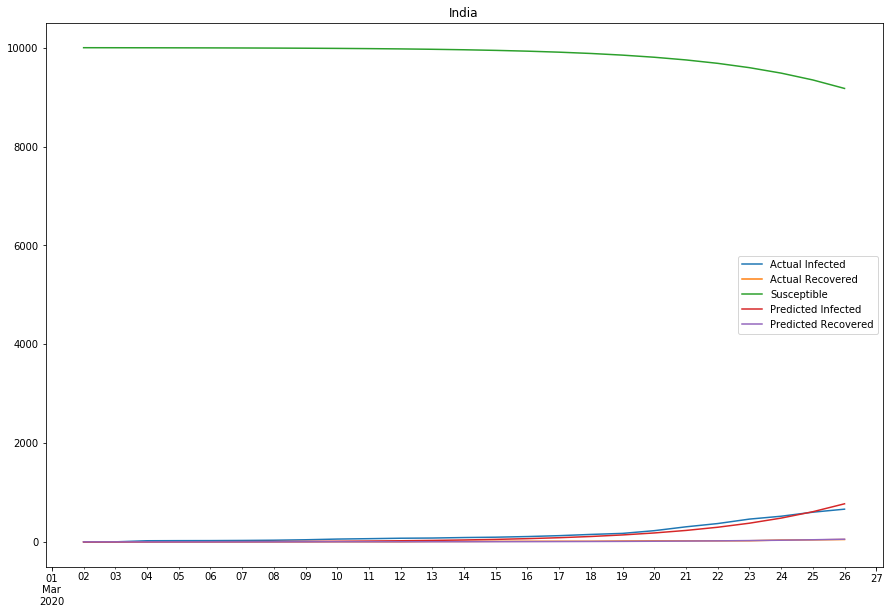

In [23]:
train(recovered, infected, data)

### Lockdown Period

In [24]:
dbd_tc_param.head(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
0,2020-03-27,883,75,19,789
1,2020-03-28,1019,85,24,910


In [25]:
dbd_tc_param.tail(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
18,2020-04-14,11490,1365,398,9727
19,2020-04-15,12322,1498,423,10401


In [26]:
data = dbd_tc_param.set_index('Date')['Total Active Cases']
infected = dbd_tc_param.set_index('Date')['Total Confirmed']
recovered = dbd_tc_param.set_index('Date')['Total Recovered']

In [27]:
s_0 = 50000
i_0 = 789
r_0 = 75

In [28]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [29]:
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-04-16', periods=30)))))

In [30]:
def predict(beta, gamma, data, recovered, s_0, i_0, r_0):
    new_index = pres_fut
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

In [31]:
def train(recovered, infected, data):
    recovered = recovered
    infected = infected
    data = data

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.000001, 0.5), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, prediction = predict(beta, gamma, data, recovered, s_0, i_0, r_0)
    df = pd.DataFrame({'Actual Infected': extended_actual, 'Actual Recovered': extended_recovered, 'Susceptible': prediction.y[0], 'Predicted Infected': prediction.y[1], 'Predicted Recovered': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('India')
    df.plot(ax=ax)
    print(f"country=India, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
    fig.savefig(f"LD India.png")

      fun: 74.30119848745716
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.91016051e+03, -4.63633398e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 201
      nit: 22
   status: 0
  success: True
        x: array([3.43293185e-06, 1.87067327e-02])
country=India, beta=0.00000343, gamma=0.01870673, r_0:0.00018351


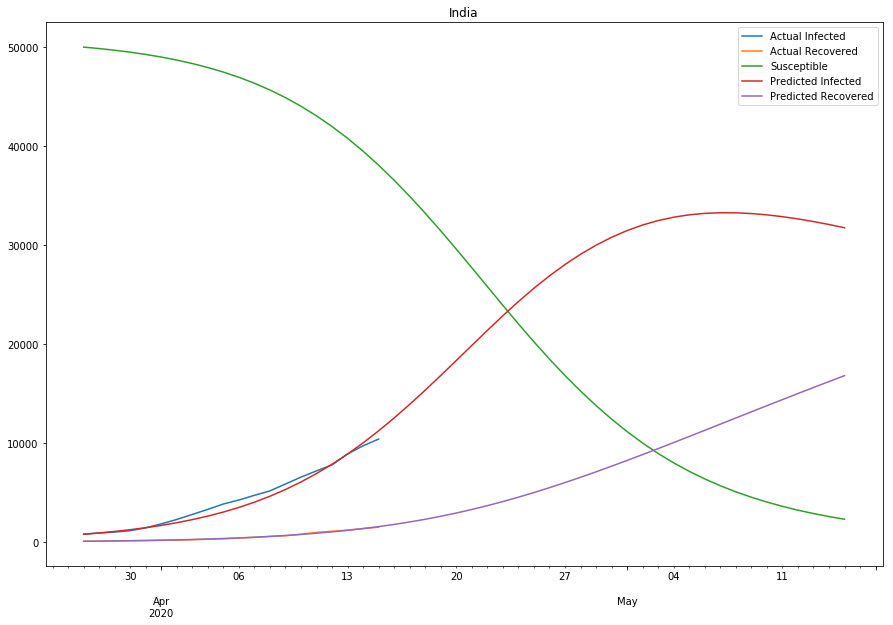

In [32]:
train(recovered, infected, data)

- **Due to lockdown the Beta reduced by 85%**
- **Recovery Rate has also improved by 2.8%**

## State-Wise Analysis

### Tamil Nadu

In [33]:
dbd_tc_tamilnadu = pd.read_excel('COVID19 India Complete Dataset April 2020.xlsx', sheet_name='Date-Wise growth in each State')
dbd_tc_tamilnadu = dbd_tc_tamilnadu[['Date', 'Status', "TN"]]
dbd_tc_tamilnadu.head(2)

,Date,Status,TN
0,2020-03-14,Confirmed,1
1,2020-03-14,Recovered,0


In [34]:
df_tn_con = dbd_tc_tamilnadu[dbd_tc_tamilnadu['Status']=='Confirmed']
df_tn_rec = dbd_tc_tamilnadu[dbd_tc_tamilnadu['Status']=='Recovered']
df_tn_dec = dbd_tc_tamilnadu[dbd_tc_tamilnadu['Status']=='Deceased']

df_tn_con.reset_index(drop=True, inplace=True)
df_tn_rec.reset_index(drop=True, inplace=True)
df_tn_dec.reset_index(drop=True, inplace=True)

In [35]:
for i in range(1, len(df_tn_con)):
    df_tn_con.loc[i, 'TN'] = df_tn_con.loc[i-1, 'TN'] + df_tn_con.loc[i, 'TN']
    df_tn_rec.loc[i, 'TN'] = df_tn_rec.loc[i-1, 'TN'] + df_tn_rec.loc[i, 'TN']
    df_tn_dec.loc[i, 'TN'] = df_tn_dec.loc[i-1, 'TN'] + df_tn_dec.loc[i, 'TN']

In [36]:
df_tn_con.rename(columns={'TN':'Total Confirmed'}, inplace=True)
df_tn_con.head(2)

,Date,Status,Total Confirmed
0,2020-03-14,Confirmed,1
1,2020-03-15,Confirmed,1


In [37]:
df_tn_rec.rename(columns={'TN':'Total Recovered'}, inplace=True)
df_tn_rec.head(2)

,Date,Status,Total Recovered
0,2020-03-14,Recovered,0
1,2020-03-15,Recovered,0


In [38]:
df_tn_dec.rename(columns={'TN':'Total Deceased'}, inplace=True)
df_tn_dec.head(2)

,Date,Status,Total Deceased
0,2020-03-14,Deceased,0
1,2020-03-15,Deceased,0


In [39]:
df_tn_total = pd.merge(df_tn_con[['Date', 'Total Confirmed']], df_tn_rec[['Date', 'Total Recovered']], on=['Date'], how='left')
df_tn_total = pd.merge(df_tn_total, df_tn_dec[['Date', 'Total Deceased']], on=['Date'], how='left')
df_tn_total['Total Active Cases'] = df_tn_total['Total Confirmed'] - df_tn_total['Total Recovered'] -\
                                     df_tn_total['Total Deceased']
df_tn_total.head(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
0,2020-03-14,1,0,0,1
1,2020-03-15,1,0,0,1


#### Pre-Lockdown Period

In [40]:
data = df_tn_total[(df_tn_total['Date']) < '2020-03-27'].set_index('Date')['Total Active Cases']
infected = df_tn_total[(df_tn_total['Date']) < '2020-03-27'].set_index('Date')['Total Confirmed']
recovered = df_tn_total[(df_tn_total['Date']) < '2020-03-27'].set_index('Date')['Total Recovered']

In [41]:
s_0 = 2000
i_0 = 1
r_0 = 0

In [42]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [43]:
def predict(beta, gamma, data, recovered, s_0, i_0, r_0):
    new_index = list(data.index.values)
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

In [44]:
def train(recovered, infected, data):
    recovered = recovered
    infected = infected
    data = data

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, prediction = predict(beta, gamma, data, recovered, s_0, i_0, r_0)
    df = pd.DataFrame({'Actual Infected': extended_actual, 'Actual Recovered': extended_recovered, 'Susceptible': prediction.y[0], 'Predicted Infected': prediction.y[1], 'Predicted Recovered': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('India')
    df.plot(ax=ax)
    print(f"country=India, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
    fig.savefig(f"Tamil Nadu.png")

      fun: 0.7380174195095646
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.97140132e-05, -4.44089210e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 87
      nit: 21
   status: 0
  success: True
        x: array([0.00014701, 0.01711651])
country=India, beta=0.00014701, gamma=0.01711651, r_0:0.00858855


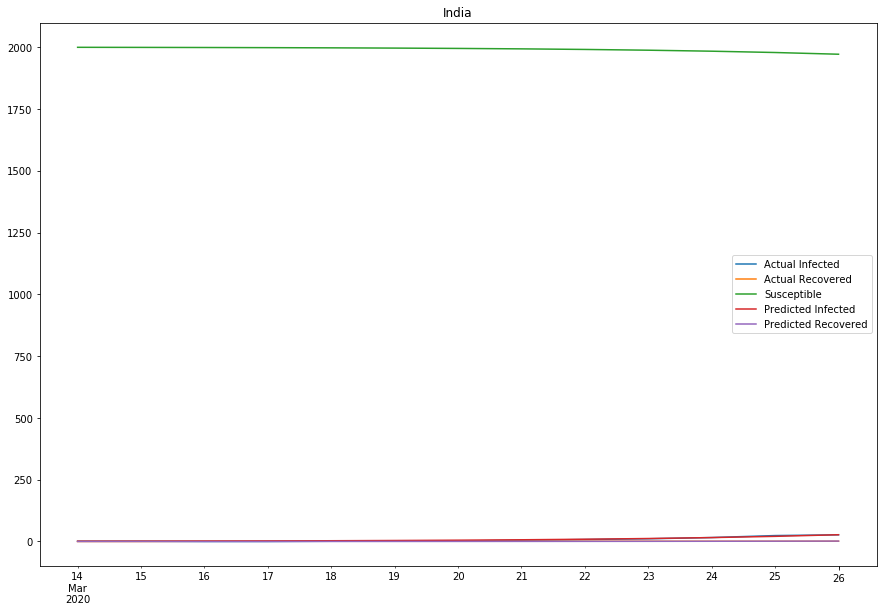

In [45]:
train(recovered, infected, data)

#### Lockdown Period

In [46]:
df_tn_total[(df_tn_total['Date']) >= '2020-03-27'].head(1)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
13,2020-03-27,38,2,1,35


In [47]:
data = df_tn_total[(df_tn_total['Date']) >= '2020-03-27'].set_index('Date')['Total Active Cases']
infected = df_tn_total[(df_tn_total['Date']) >= '2020-03-27'].set_index('Date')['Total Confirmed']
recovered = df_tn_total[(df_tn_total['Date']) >= '2020-03-27'].set_index('Date')['Total Recovered']

In [48]:
s_0 = 5000
i_0 = 35
r_0 = 2

In [49]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [50]:
def predict(beta, gamma, data, recovered, s_0, i_0, r_0):
    new_index = list(pres_fut)
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

In [51]:
def train(recovered, infected, data):
    recovered = recovered
    infected = infected
    data = data

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, prediction = predict(beta, gamma, data, recovered, s_0, i_0, r_0)
    df = pd.DataFrame({'Actual Infected': extended_actual, 'Actual Recovered': extended_recovered, 'Susceptible': prediction.y[0], 'Predicted Infected': prediction.y[1], 'Predicted Recovered': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('India')
    df.plot(ax=ax)
    print(f"country=Tamil Nadu, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
    fig.savefig(f"Tamil Nadu PL.png")

      fun: 26.032722058236644
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.18266357, -0.18762591])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 141
      nit: 19
   status: 0
  success: True
        x: array([4.58930212e-05, 1.19813650e-02])
country=Tamil Nadu, beta=0.00004589, gamma=0.01198137, r_0:0.00383037


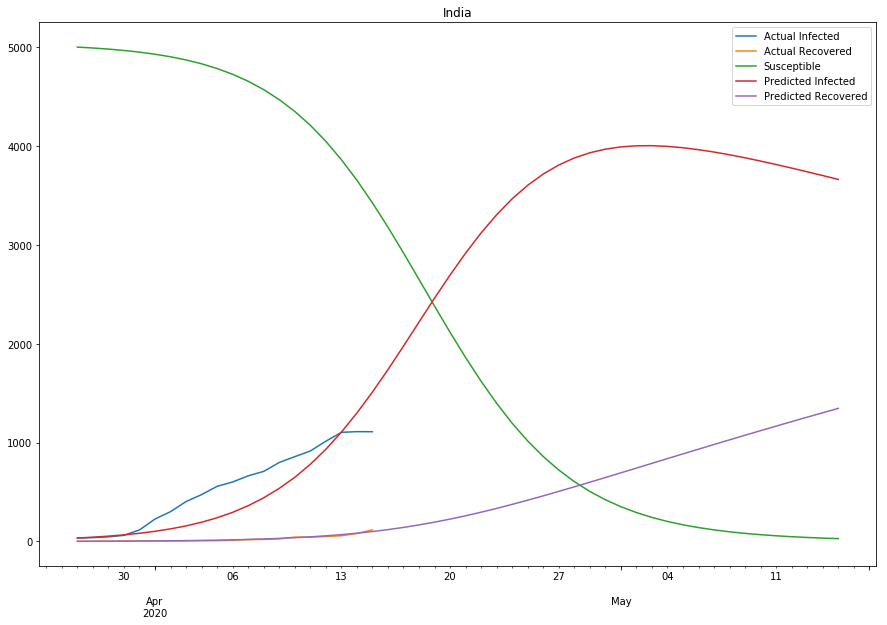

In [52]:
train(recovered, infected, data)

### Maharashtra

In [53]:
dbd_tc_maharashtra = pd.read_excel('COVID19 India Complete Dataset April 2020.xlsx', sheet_name='Date-Wise growth in each State')
dbd_tc_maharashtra = dbd_tc_maharashtra[['Date', 'Status', "MH"]]
dbd_tc_maharashtra.head(2)

,Date,Status,MH
0,2020-03-14,Confirmed,14
1,2020-03-14,Recovered,0


In [54]:
df_mh_con = dbd_tc_maharashtra[dbd_tc_maharashtra['Status']=='Confirmed']
df_mh_rec = dbd_tc_maharashtra[dbd_tc_maharashtra['Status']=='Recovered']
df_mh_dec = dbd_tc_maharashtra[dbd_tc_maharashtra['Status']=='Deceased']

df_mh_con.reset_index(drop=True, inplace=True)
df_mh_rec.reset_index(drop=True, inplace=True)
df_mh_dec.reset_index(drop=True, inplace=True)

In [55]:
for i in range(1, len(df_mh_con)):
    df_mh_con.loc[i, 'MH'] = df_mh_con.loc[i-1, 'MH'] + df_mh_con.loc[i, 'MH']
    df_mh_rec.loc[i, 'MH'] = df_mh_rec.loc[i-1, 'MH'] + df_mh_rec.loc[i, 'MH']
    df_mh_dec.loc[i, 'MH'] = df_mh_dec.loc[i-1, 'MH'] + df_mh_dec.loc[i, 'MH']

In [56]:
df_mh_con.rename(columns={'MH':'Total Confirmed'}, inplace=True)
df_mh_con.head(2)

,Date,Status,Total Confirmed
0,2020-03-14,Confirmed,14
1,2020-03-15,Confirmed,32


In [57]:
df_mh_rec.rename(columns={'MH':'Total Recovered'}, inplace=True)
df_mh_rec.head(2)

,Date,Status,Total Recovered
0,2020-03-14,Recovered,0
1,2020-03-15,Recovered,0


In [58]:
df_mh_dec.rename(columns={'MH':'Total Deceased'}, inplace=True)
df_mh_dec.head(2)

,Date,Status,Total Deceased
0,2020-03-14,Deceased,0
1,2020-03-15,Deceased,0


In [59]:
df_mh_total = pd.merge(df_mh_con[['Date', 'Total Confirmed']], df_mh_rec[['Date', 'Total Recovered']], on=['Date'], how='left')
df_mh_total = pd.merge(df_mh_total, df_mh_dec[['Date', 'Total Deceased']], on=['Date'], how='left')
df_mh_total['Total Active Cases'] = df_mh_total['Total Confirmed'] - df_mh_total['Total Recovered'] -\
                                     df_mh_total['Total Deceased']
df_mh_total.head(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
0,2020-03-14,14,0,0,14
1,2020-03-15,32,0,0,32


#### Pre-Lockdown Period

In [60]:
data = df_mh_total[(df_mh_total['Date']) < '2020-03-27'].set_index('Date')['Total Active Cases']
infected = df_mh_total[(df_mh_total['Date']) < '2020-03-27'].set_index('Date')['Total Confirmed']
recovered = df_mh_total[(df_mh_total['Date']) < '2020-03-27'].set_index('Date')['Total Recovered']

In [61]:
s_0 = 5000
i_0 = 1
r_0 = 0

In [62]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [63]:
def predict(beta, gamma, data, recovered, s_0, i_0, r_0):
    new_index = list(data.index.values)
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

In [64]:
def train(recovered, infected, data):
    recovered = recovered
    infected = infected
    data = data

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, prediction = predict(beta, gamma, data, recovered, s_0, i_0, r_0)
    df = pd.DataFrame({'Actual Infected': extended_actual, 'Actual Recovered': extended_recovered, 'Susceptible': prediction.y[0], 'Predicted Infected': prediction.y[1], 'Predicted Recovered': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('India')
    df.plot(ax=ax)
    print(f"country=Maharashtra, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
    fig.savefig(f"Maharashtra.png")

      fun: 3.7866919900278977
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.66722616, -0.01535434])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 108
      nit: 9
   status: 0
  success: True
        x: array([8.59569500e-05, 2.46674187e-03])
country=Maharashtra, beta=0.00008596, gamma=0.00246674, r_0:0.03484635


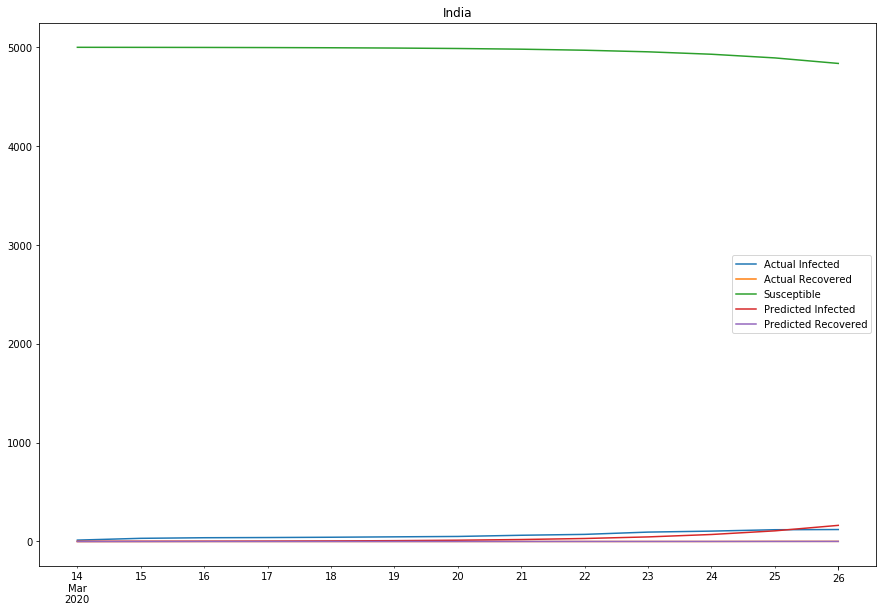

In [65]:
train(recovered, infected, data)

#### Lockdown Period

In [66]:
df_mh_total[(df_mh_total['Date']) >= '2020-03-27'].head(1)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
13,2020-03-27,156,19,4,133


In [67]:
data = df_mh_total[(df_mh_total['Date']) >= '2020-03-27'].set_index('Date')['Total Active Cases']
infected = df_mh_total[(df_mh_total['Date']) >= '2020-03-27'].set_index('Date')['Total Confirmed']
recovered = df_mh_total[(df_mh_total['Date']) >= '2020-03-27'].set_index('Date')['Total Recovered']

In [68]:
s_0 = 10000
i_0 = 35
r_0 = 2

In [69]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [70]:
def predict(beta, gamma, data, recovered, s_0, i_0, r_0):
    new_index = list(pres_fut)
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

In [71]:
def train(recovered, infected, data):
    recovered = recovered
    infected = infected
    data = data

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, prediction = predict(beta, gamma, data, recovered, s_0, i_0, r_0)
    df = pd.DataFrame({'Actual Infected': extended_actual, 'Actual Recovered': extended_recovered, 'Susceptible': prediction.y[0], 'Predicted Infected': prediction.y[1], 'Predicted Recovered': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('India')
    df.plot(ax=ax)
    print(f"country=Maharashtra, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
    fig.savefig(f"Maharashtra PL.png")

      fun: 54.41375804278837
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.38995908e+03, 1.09218590e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 153
      nit: 15
   status: 0
  success: True
        x: array([2.77014865e-05, 2.72664545e-02])
country=Maharashtra, beta=0.00002770, gamma=0.02726645, r_0:0.00101595


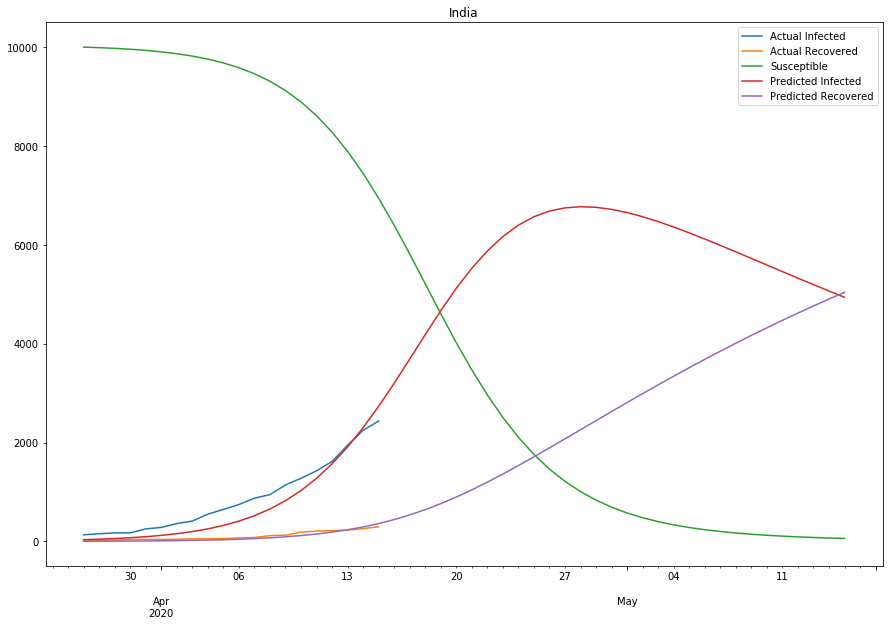

In [72]:
train(recovered, infected, data)